<a href="https://colab.research.google.com/github/TheBlock98/Thesis2/blob/main/CorrelationMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip install pandas_ta
! pip install pandas
! pip install finta
! pip install seaborn



import pandas as pd
from finta import TA
import pandas_ta as pta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd


In [ ]:

def makeDataSet(extended=False):
  dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/BTCUSDT-spot-1h.csv",parse_dates=True)

  SpxData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/^SPX.csv", parse_dates=True)
  SpxData.rename(columns={'Date': 'date'}, inplace=True)
  SpxData.set_index('date', inplace=True)

  DxyData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/DX-Y.NYB.csv", parse_dates=True)
  DxyData.rename(columns={'Date': 'date'}, inplace=True)
  DxyData.set_index('date', inplace=True)

  DIXGEXData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/DIX.csv", parse_dates=True)
  DIXGEXData.rename(columns={'Date': 'date'}, inplace=True)
  DIXGEXData.set_index('date', inplace=True)
  dataSet = dataSet.iloc[1:]

  # Feature extraction using both `finta` and `pandas_ta`

  # Exponential Moving Average (EMA) features
  dataSet["EMA_21"] = TA.EMA(dataSet, 21)
  dataSet["EMA_50"] = TA.EMA(dataSet, 50)
  dataSet["EMA_200"] = TA.EMA(dataSet, 200)
  dataSet["HLC3"] = (dataSet["close"]  + dataSet["high"] + dataSet["low"] ) / 3

  # Average True Range (ATR) features
  dataSet["ATR"] = TA.ATR(dataSet, 24)  # Daily ATR
  dataSet["ATR_168"] = TA.ATR(dataSet, 168)  # Weekly ATR

  # Relative Strength Index (RSI)
  dataSet["RSI"] = TA.RSI(dataSet, 14)

  # Moving Average Convergence Divergence (MACD)
  macd_data = TA.MACD(dataSet)
  dataSet["MACD_line"] = macd_data["MACD"]
  dataSet["MACD_signal"] = macd_data["SIGNAL"]

  # Hull Moving Average (HMA) features

  dataSet["HMA_24"] = pta.hma(dataSet["close"], 24)

  # Bollinger Bands (BB) features
  bbands_10_data = pta.bbands(dataSet["close"], length=10, std=1.5)
  bbands_20_data = pta.bbands(dataSet["close"], length=20, std=2)
  bbands_50_data = pta.bbands(dataSet["close"], length=50, std=2.5)

  # Join BB data to the main dataset
  dataSet = dataSet.join(bbands_10_data)
  dataSet = dataSet.join(bbands_20_data)
  dataSet = dataSet.join(bbands_50_data)

  # More indicators
  dataSet["ebws"] = pta.ebsw(dataSet["close"])
  fisher_data = pta.fisher(dataSet["high"], dataSet["low"], 16)
  dataSet["FISHER"] = fisher_data.iloc[:, 0]
  dataSet["FISHERT"] = fisher_data.iloc[:, 1]

  # Detrended Price Oscillator (DPO)
  dataSet["DPO14"] = pta.dpo(close=dataSet['close'], length=14, centered=False)
  # Convert the 'date' column to a datetime format
  dataSet['date'] = pd.to_datetime(dataSet['date'])

# Set the 'date' column as the index
  dataSet = dataSet.set_index('date')


  dataSetD = dataSet.resample('D').agg({
      'open': 'first',  # Primo valore del giorno
      'high': 'max',  # Massimo valore delle 24 ore
      'low': 'min',  # Minimo valore delle 24 ore
      'close': 'last'  # Ultimo valore del giorno
  })

  previous_day = dataSetD.shift(1)
  pp = (dataSetD['high'] + dataSetD['low'] + dataSetD['close']) / 3

  r4 = pp + ((previous_day["high"] - previous_day["low"]) * 1.382)
  r3 = pp + ((previous_day["high"] - previous_day["low"]) * 1)
  r2 = pp + ((previous_day["high"] - previous_day["low"]) * 0.618)
  r1 = pp + ((previous_day["high"] - previous_day["low"]) * 0.382)

  s1 = pp - ((previous_day["high"] - previous_day["low"]) * 0.382)
  s2 = pp - ((previous_day["high"] - previous_day["low"]) * 0.618)
  s3 = pp - ((previous_day["high"] - previous_day["low"]) * 1)
  s4 = pp - ((previous_day["high"] - previous_day["low"]) * 1.382)

  # Combine the pivot levels into a single DataFrame
  pivot_data = pd.DataFrame(
      {
          'pivot': pp,
          's1': s1,
          's2': s2,
          's3': s3,
          's4': s4,
          'r1': r1,
          'r2': r2,
          'r3': r3,
          'r4': r4
      },
      index=dataSetD.index)
  # Merge the pivot data for each day into each row of hourly data that falls under that day
  dataSet = pd.merge_asof(dataSet.sort_index(),
                          pivot_data.sort_index(),
                          left_index=True,
                          right_index=True,
                          direction='backward')

  # 35, 18, 10
  # Future Line of Demarcation (FLD)
  for period in [97, 193, 385]:  # Organize the periods to calculate FLD
    src = (dataSet["close"]  + dataSet["high"] + dataSet["low"] ) / 3
    dataSet[f'FLD{period}'] = src.shift(period)
    dataSet[f'FLD{period}'].fillna(0, inplace=True)



  # Volume Weighted Average Price (VWAP)
  dataSet["D-VWAP"] = pta.vwap(high=dataSet["high"],
                              low=dataSet["low"],
                              close=dataSet["close"],
                              volume=dataSet["volume"])
  dataSet["W-VWAP"] = pta.vwap(high=dataSet["high"],
                              low=dataSet["low"],
                              close=dataSet["close"],
                              volume=dataSet["volume"],
                              anchor="W")

  # Volume Weighted Moving Average (VWMA)
  dataSet["VWMA"] = pta.vwma(close=dataSet["close"],
                            volume=dataSet["volume"],
                            length=20)

  # Easy of market move
  dataSet["EOM"] = pta.eom(high=dataSet["high"],
                          low=dataSet["low"],
                          close=dataSet["close"],
                          volume=dataSet["volume"])

  # Money flow index:
  dataSet["MFI"] = pta.mfi(high=dataSet["high"],
                          low=dataSet["low"],
                          close=dataSet["close"],
                          volume=dataSet["volume"],
                          length=14)

  SpxData.drop(SpxData.index[:2])
  DxyData.drop(DxyData.index[:3])
  SpxData.fillna(method='ffill', inplace=True)
  DxyData.fillna(method='ffill', inplace=True)

  #print("_____ test IMR 1________ ")
  #print(SpxData.head())
  #print(DxyData.head(-1))
  #print("______________________")
  # inter-market relation (IMR)
  SpxData['SPX500-DailyReturn%'] = SpxData['Close'].pct_change() * 100
  SpxData['SPXEMA20'] = TA.EMA(SpxData, 20)

  DxyData['DXY-DailyReturn%'] = DxyData['Close'].pct_change() * 100
  DxyData['DXYEMA200'] = TA.EMA(DxyData, 200)

  dataSetIMR = dataSet  # in this way we can test if IMR is useful or not

  #SpxData.drop(SpxData.index[:7168])
  #DxyData.drop(DxyData.index[:7168])

  #print("_____ test IMR 2________ ")
  #print(SpxData.head())
  #print(DxyData.head(-1))
  #print("______________________")

  SpxData.index = pd.to_datetime(SpxData.index)
  DxyData.index = pd.to_datetime(DxyData.index)
  DIXGEXData.index = pd.to_datetime(DIXGEXData.index)
  SpxData.index = SpxData.index.tz_localize(None)
  DxyData.index = DxyData.index.tz_localize(None)
  DIXGEXData.index = DIXGEXData.index.tz_localize(None)
  dataSetIMR.index = dataSetIMR.index.tz_localize(
      None) if dataSetIMR.index.tz is not None else dataSetIMR.index

  #print("test DIX ______________")
  #print(DIXGEXData.head())
  #print(DIXGEXData.head(-1))
  #print("______________________")

  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            SpxData[['SPX500-DailyReturn%', 'SPXEMA20']],
                            left_index=True,
                            right_index=True,
                            direction='backward')
  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            DxyData[['DXY-DailyReturn%', 'DXYEMA200']],
                            left_index=True,
                            right_index=True,
                            direction='backward')
  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            DIXGEXData[['dix', 'gex']],
                            left_index=True,
                            right_index=True,
                            direction='backward')

  #print("test dataSetIMR ______________")
  #print(dataSetIMR.head())
  #print(dataSetIMR.head(-1))
  #print("______________________")
  # Find the index of the first non-NaN row across all columns
  first_valid_index = dataSetIMR.dropna().index[0]

  first_valid_location = dataSetIMR.index.get_loc(first_valid_index)

  dataSetIMRCleaned = dataSetIMR.iloc[first_valid_location:]

  #print(dataSetIMR[['SPXEMA20', 'DXYEMA200']].dtypes)
  #print(dataSetIMR[['SPXEMA20', 'DXYEMA200']])

  # dataSetIMR.fillna(method='ffill', inplace=True)  # ho le chiusure del weekand così risolvo il problema

  dataSetIMRCleaned = dataSetIMRCleaned.select_dtypes(
      include=['float64', 'int64'])
  dataSetIMRCleaned['SPX500-DailyReturn%'] = pd.to_numeric(
      dataSetIMRCleaned['SPX500-DailyReturn%'], errors='coerce')
  dataSetIMRCleaned['DXY-DailyReturn%'] = pd.to_numeric(
      dataSetIMRCleaned['DXY-DailyReturn%'], errors='coerce')

  dataSetIMRCleaned['EOM'].fillna(0, inplace=True)

  dataSet.replace([np.inf, -np.inf], 0, inplace=True)

  pd.set_option('display.max_columns', None)

  #print("test dataSetIMR ______________")
  #print(dataSetIMRCleaned)
  #dataSetIMRCleaned.info()
  #print("______________________")
  #dataSetIMRCleaned.to_csv('FeatureEngineering&DATA/dataSetIMRCleanedHLC3.csv',index=False)
  #dataSetIMRCleaned.head()

  return dataSetIMRCleaned

In [11]:
dataSet = makeDataSet()

<ipython-input-6-06ddea6bc8b2>:130: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["D-VWAP"] = pta.vwap(high=dataSet["high"],
<ipython-input-6-06ddea6bc8b2>:134: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["W-VWAP"] = pta.vwap(high=dataSet["high"],


## Corr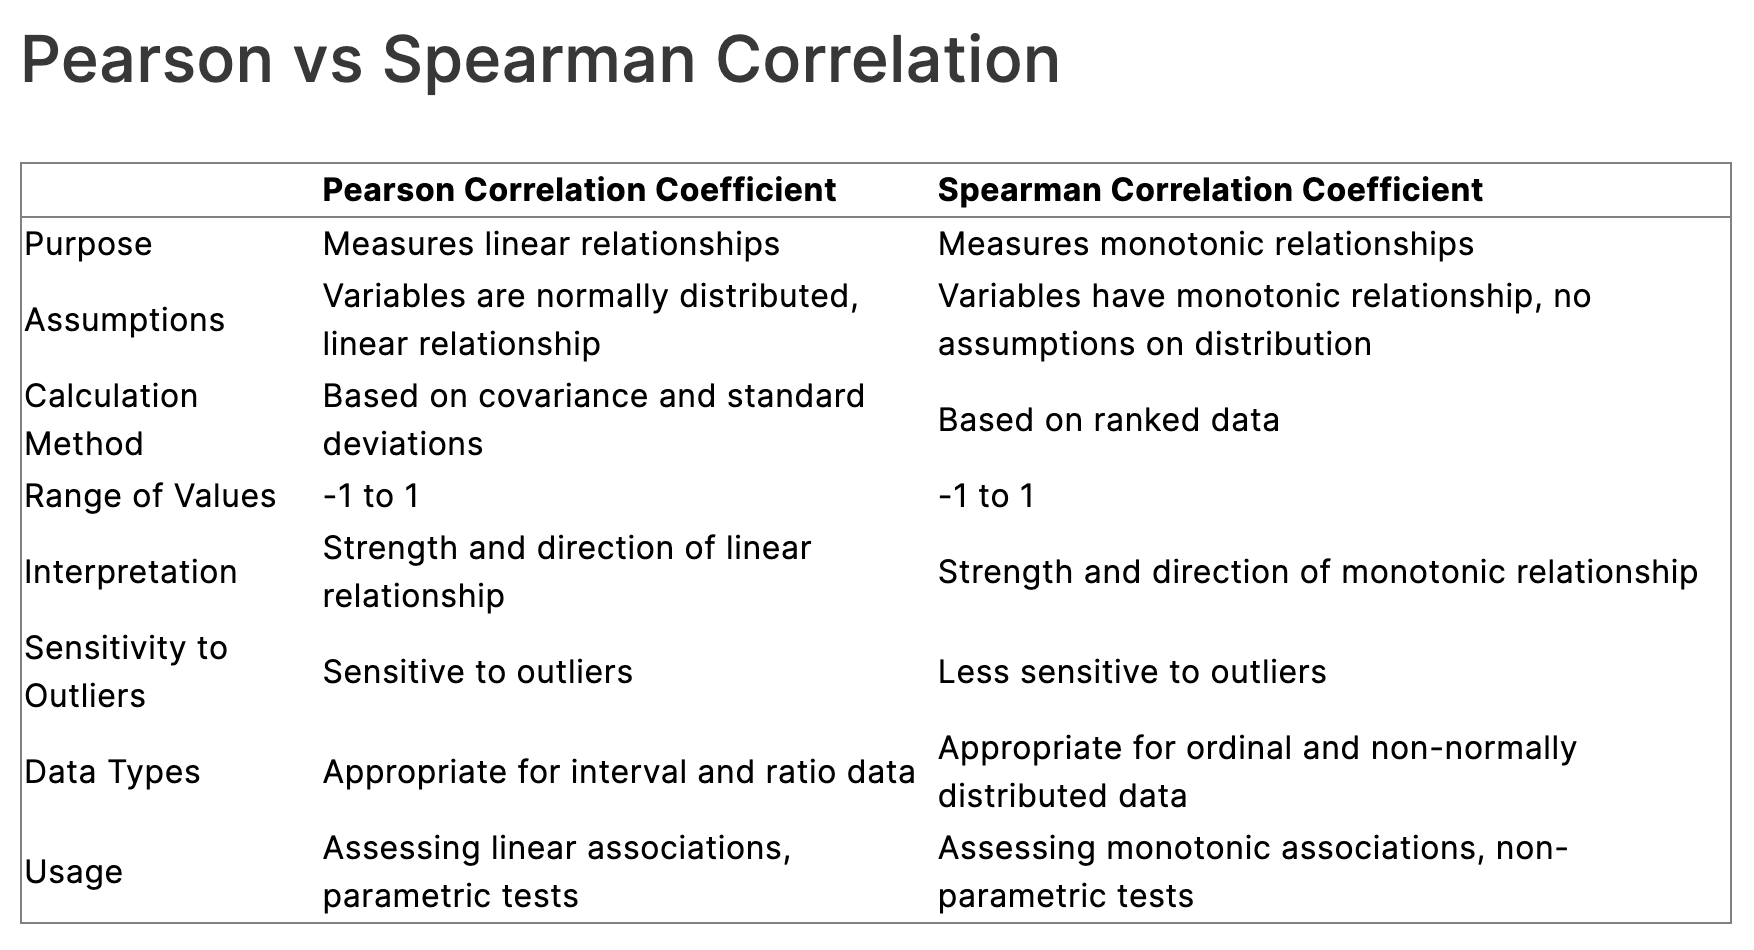elation matrix




The Pearson correlation coefficient (r) is a measure of linear relationship between two variables.


$$
r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{n\sum x^2 - (\sum x)^2}\sqrt{n\sum y^2 - (\sum y)^2}}
$$






Here,

n is the number of data points
* $(\sum xy)$  is the sum of the product of corresponding values of x and y
* $(\sum x)$ is the sum of all the values of x
* $(\sum y )$ is the sum of all the values of y
* $(\sum x^2)$ is the sum of the squares of all values of x
* $(\sum y^2)$ is the sum of the squares of all the of y







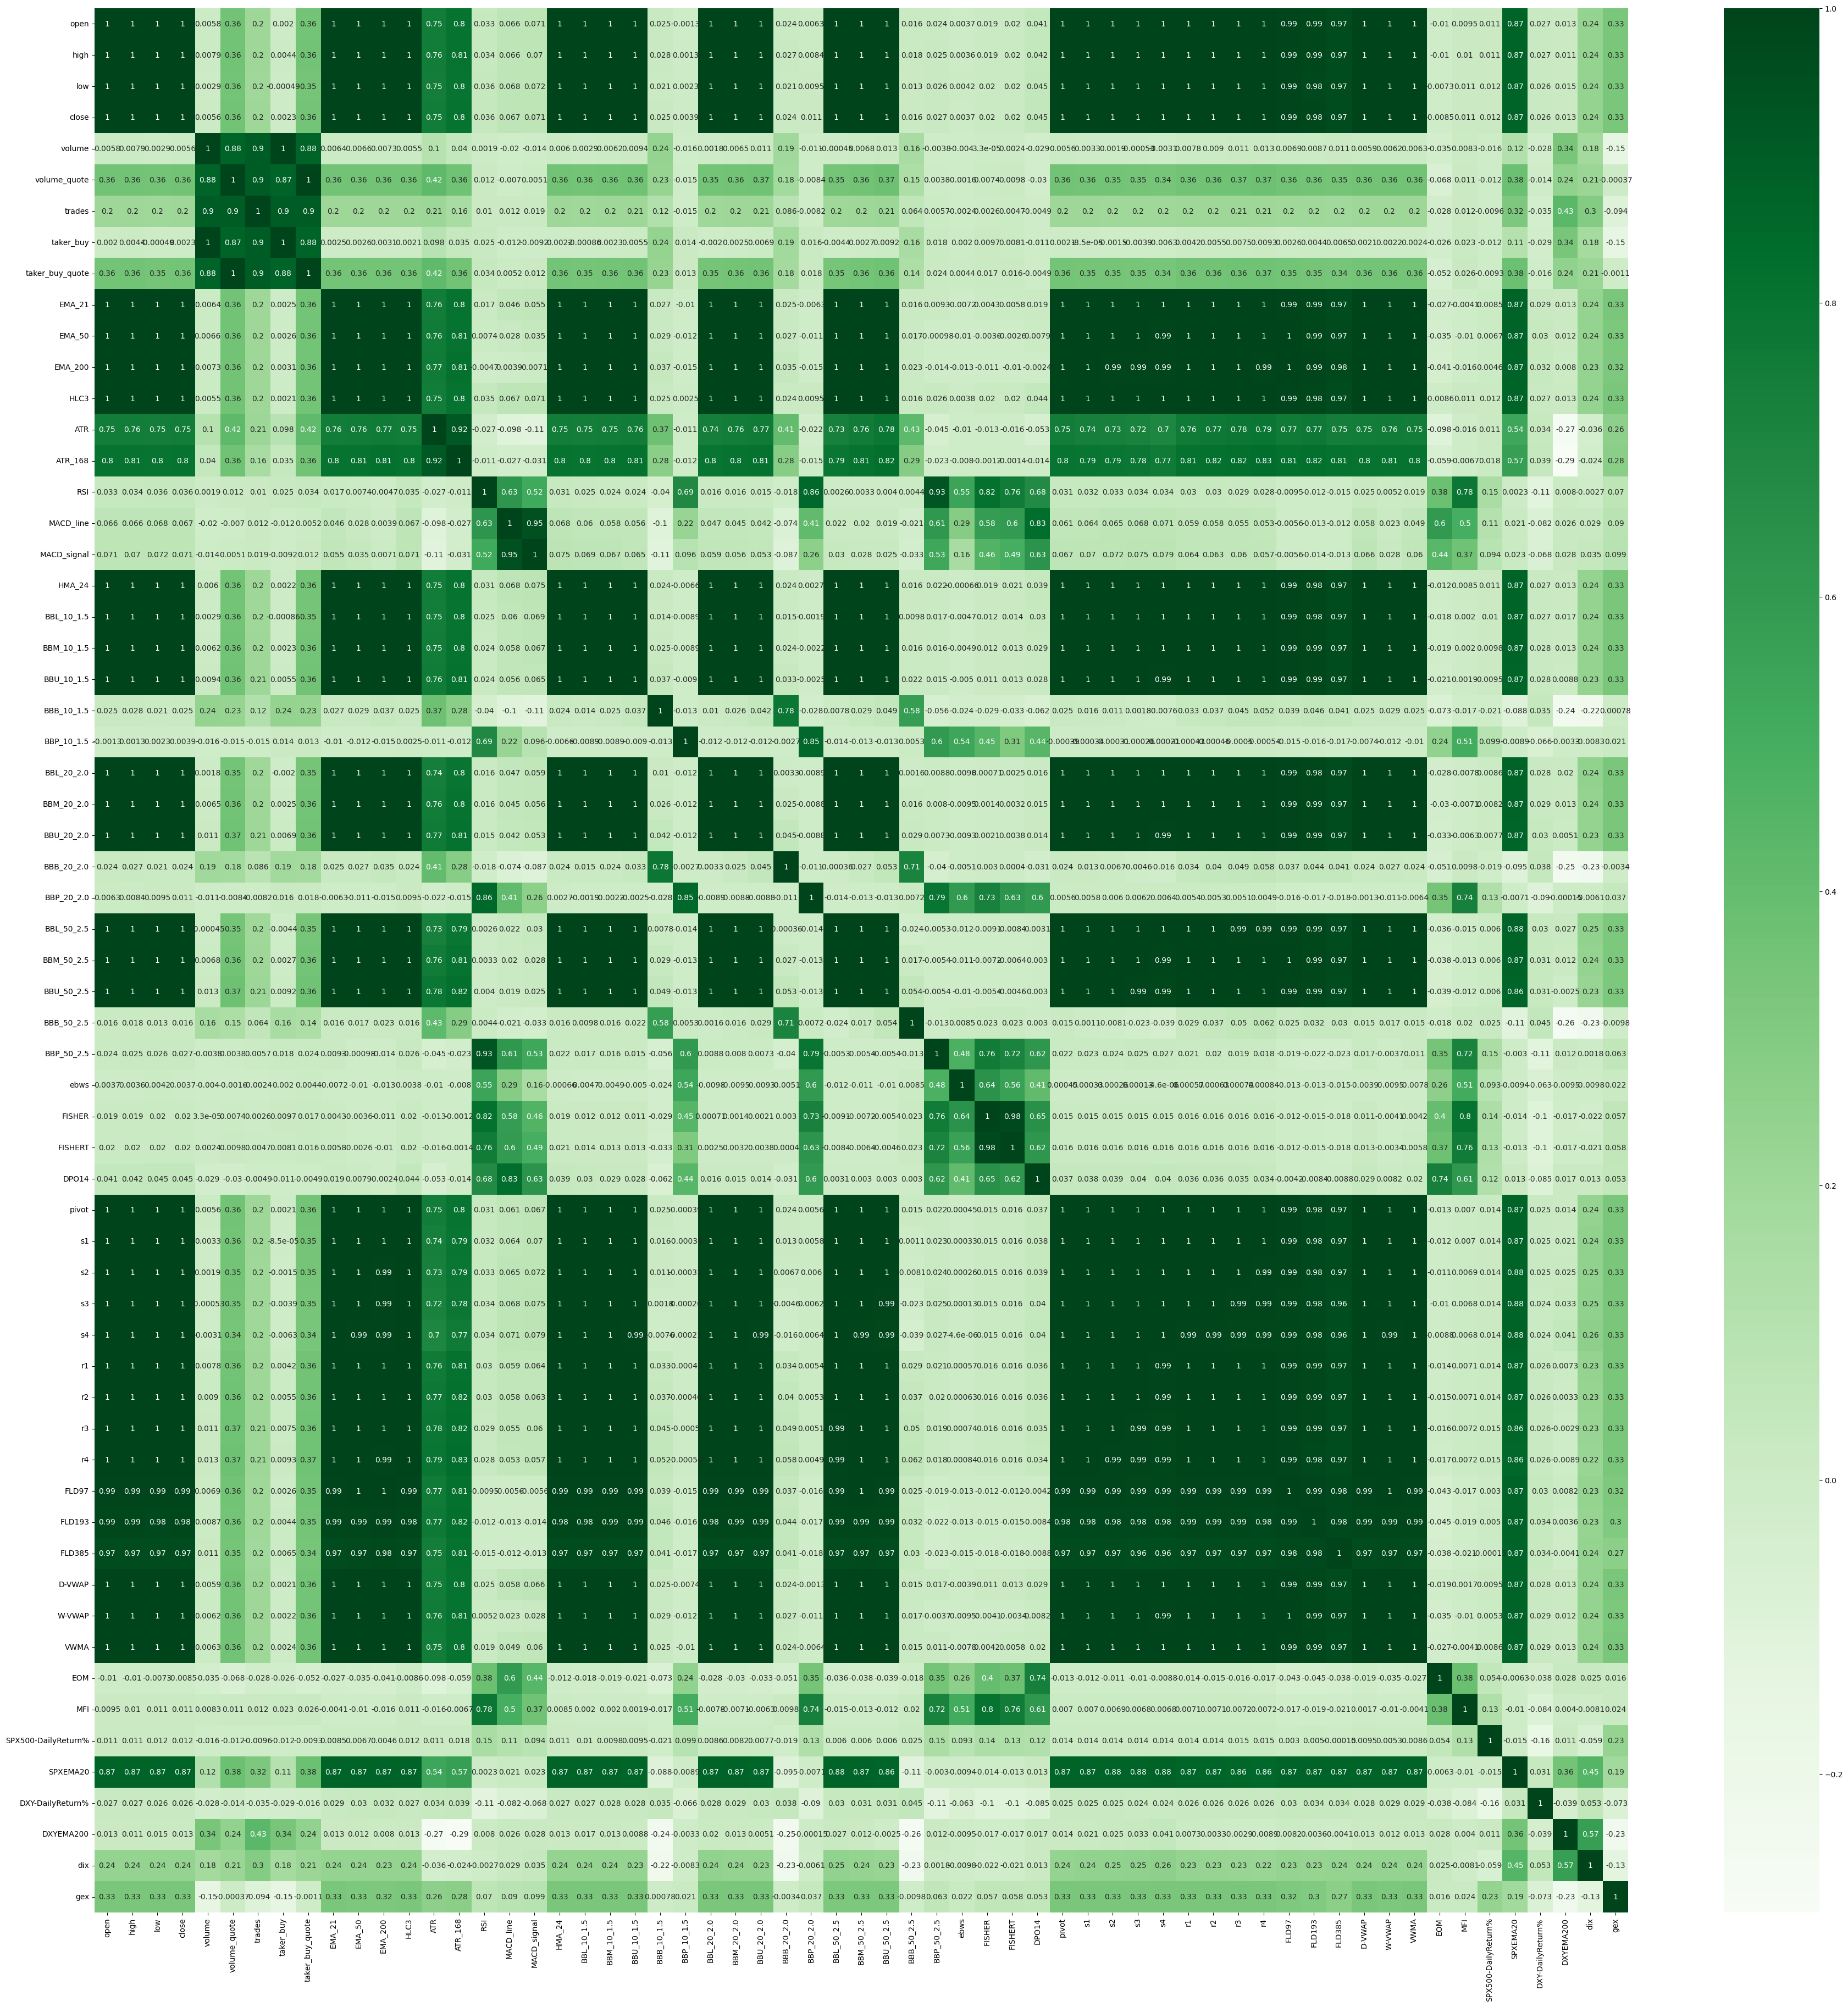

In [17]:
matrix = dataSet.corr(method='pearson')
plt.figure(figsize=(45, 45))
sns.heatmap(matrix, cmap="Greens", annot=True)
plt.show()

Spearman’s rank correlation coefficient
The Spearman’s rank correlation coefficient is a measure of statistical dependence between two variables. It is based on the ranks of the data rather than the actual data values.

$$ \rho = 1 – \frac{6 \sum d^2}{n(n^2 -1)} $$


Here,

n is the number of paired observations
d is the difference between the rank of corresponding values of the two variables.

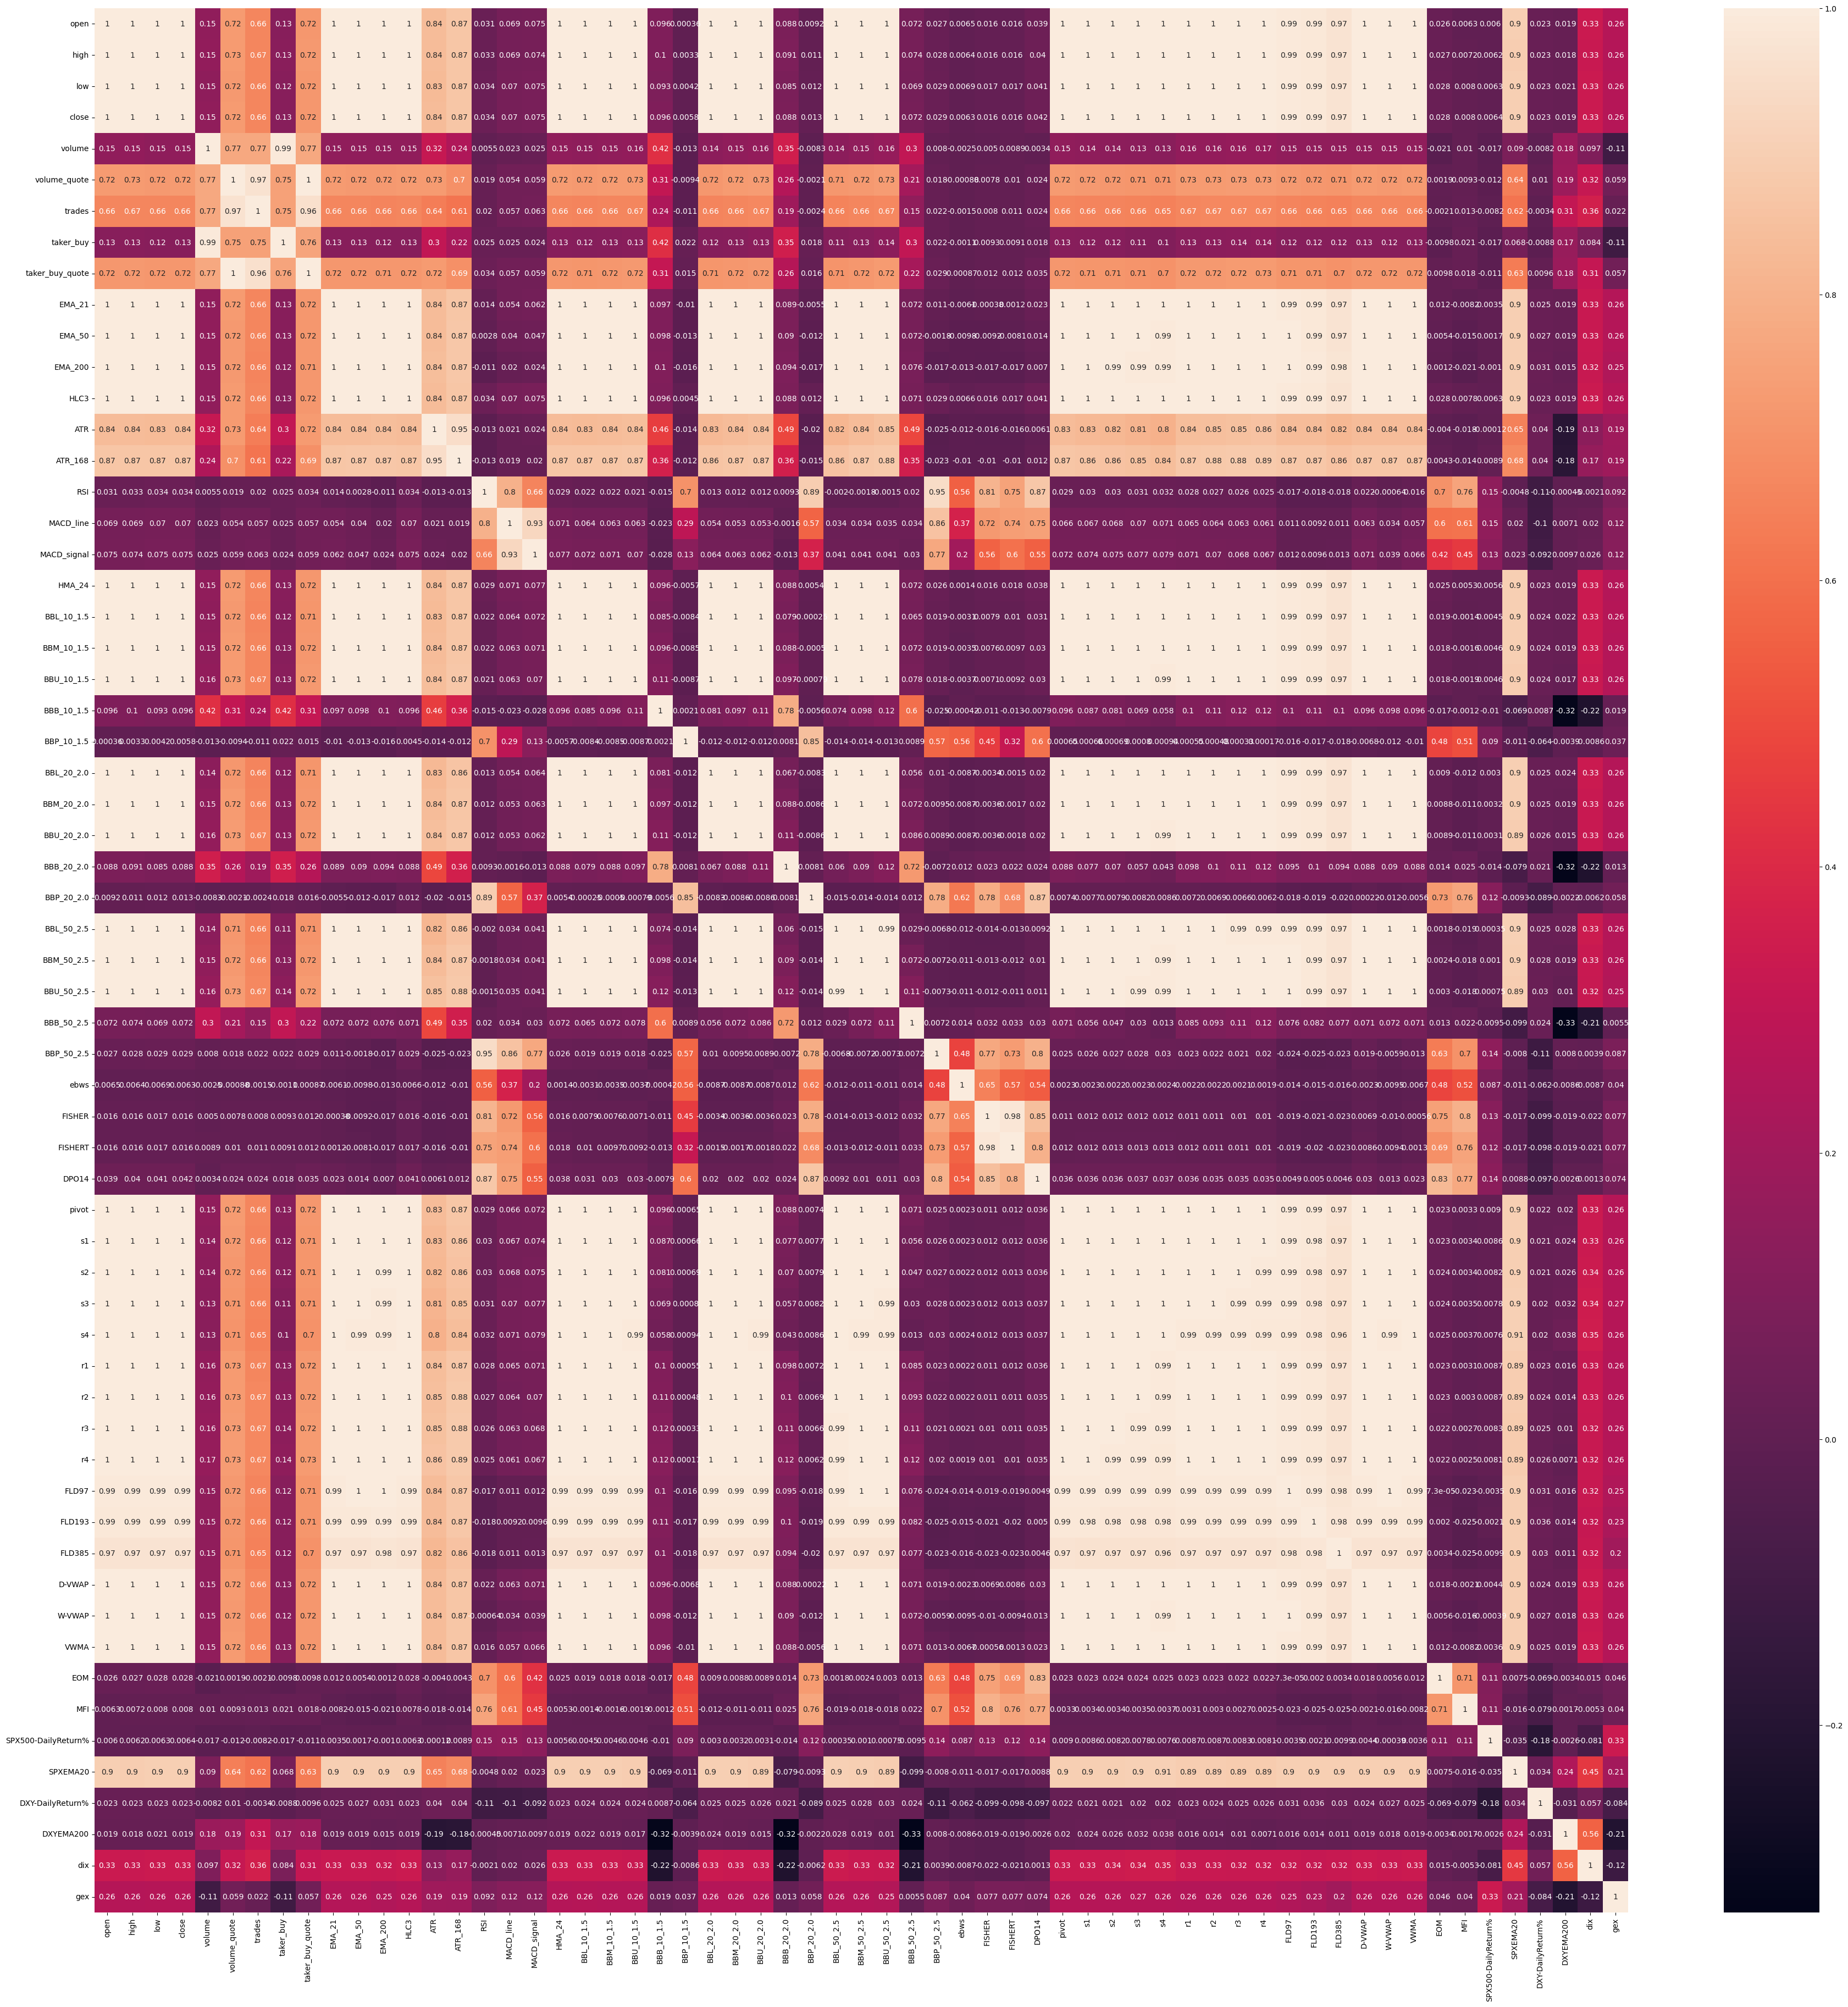

In [18]:
corr = dataSet.corr(method = 'spearman')
plt.figure(figsize=(45, 45))
sns.heatmap(corr, annot = True)
plt.show()

In [9]:
dataSet.head()

open      high       low     close      volume  \
date                                                                      
2018-01-08 00:00:00  16218.85  16322.30  15908.06  15948.96  581.369323   
2018-01-08 01:00:00  15941.93  16001.80  15655.00  15850.07  878.804115   
2018-01-08 02:00:00  15850.08  16100.00  15830.01  16037.38  765.781916   
2018-01-08 03:00:00  16030.01  16031.99  15514.99  15670.37  948.188780   
2018-01-08 04:00:00  15632.48  15840.00  15510.00  15641.01  638.906874   

                     volume_quote  trades   taker_buy  taker_buy_quote  \
date                                                                     
2018-01-08 00:00:00  9.402066e+06    5769  298.923593     4.838329e+06   
2018-01-08 01:00:00  1.390338e+07    8668  447.956068     7.090322e+06   
2018-01-08 02:00:00  1.221753e+07    5479  451.048469     7.197826e+06   
2018-01-08 03:00:00  1.492223e+07    8005  461.787783     7.274616e+06   
2018-01-08 04:00:00  1.003079e+07    6129  357.267064     5.612546e+06   

                           EMA_21        EMA_50       EMA_200          HLC3  \
date                                                                          
2018-01-08 00:00:00  16319.713802  16322.416459  15631.178815  16059.773333   
2018-01-08 01:00:00  16277.018907  16303.871590  15633.849651  15835.623333   
2018-01-08 02:00:00  16255.233550  16293.409297  15638.762331  15989.130000   
2018-01-08 03:00:00  16202.064132  16268.950234  15639.146277  15739.116667   
2018-01-08 04:00:00  16151.059207  16244.299805  15639.168867  15663.670000   

                            ATR     ATR_168        RSI   MACD_line  \
date                                                                 
2018-01-08 00:00:00  305.745833  321.868036  39.632653 -134.702893   
2018-01-08 01:00:00  310.789167  322.053512  37.735016 -154.042373   
2018-01-08 02:00:00  311.331667  321.038512  43.275224 -152.496838   
2018-01-08 03:00:00  324.973333  322.847798  36.434572 -178.825191   
2018-01-08 04:00:00  324.528333  322.899762  35.945064 -199.757028   

                     MACD_signal        HMA_24    BBL_10_1.5  BBM_10_1.5  \
date                                                                       
2018-01-08 00:00:00  -107.495224  16017.502853  15835.356908   16124.879   
2018-01-08 01:00:00  -116.804654  15986.300985  15800.024856   16065.921   
2018-01-08 02:00:00  -123.943090  15959.020995  15805.322082   16069.660   
2018-01-08 03:00:00  -134.919511  15912.043289  15758.352743   16056.696   
2018-01-08 04:00:00  -147.887014  15856.144085  15666.234692   16018.872   

                       BBU_10_1.5  BBB_10_1.5  BBP_10_1.5    BBL_20_2.0  \
date                                                                      
2018-01-08 00:00:00  16414.401092    3.590999    0.196191  15789.768227   
2018-01-08 01:00:00  16331.817144    3.310064    0.094107  15721.755452   
2018-01-08 02:00:00  16333.997918    3.289901    0.438942  15692.162743   
2018-01-08 03:00:00  16355.039257    3.716123   -0.147452  15615.253770   
2018-01-08 04:00:00  16371.509308    4.402773   -0.035766  15547.402034   

                     BBM_20_2.0    BBU_20_2.0  BBB_20_2.0  BBP_20_2.0  \
date                                                                    
2018-01-08 00:00:00  16356.8965  16924.024773    6.934424    0.140349   
2018-01-08 01:00:00  16321.2000  16920.644548    7.345594    0.107028   
2018-01-08 02:00:00  16302.2165  16912.270257    7.484304    0.282940   
2018-01-08 03:00:00  16248.3855  16881.517230    7.793165    0.043527   
2018-01-08 04:00:00  16194.4850  16841.567966    7.991399    0.072331   

                       BBL_50_2.5  BBM_50_2.5    BBU_50_2.5  BBB_50_2.5  \
date                                                                      
2018-01-08 00:00:00  15794.378510  16555.4910  17316.603490    9.194683   
2018-01-08 01:00:00  15747.205950  16533.2846  17319.363250    9.509044   
2018-01-08 02:00:00  15727.079323  16514.0722  17301.065077    9